In [1]:
import os
import sys
sys.path.append(os.path.abspath('../scripts'))
fig_path      = '../figures/'
data_path     = '../data/'

In [2]:
import netCDF4 as nc
import numpy as np
import xarray as xr
import warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd 
import seaborn as sns
import cmocean as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from proj_utils import *
from mapping_utils import *
from plotting_utils import *

In [3]:
gsi_c = '#648fff'
nao_c = '#dc267f'
eap_c = '#fe6100'

## (1) Load and filter time series 

In [4]:
gsi = xr.open_dataarray(data_path + 'gsi_altimetry_timeseries.nc')
nao = xr.open_dataarray(data_path + 'nao_era5_timeseries.nc')
eap = xr.open_dataarray(data_path + 'eap_era5_timeseries.nc')

In [5]:
# --- Filter the time series with Lanczos bandpass filter ---
gsi_f    = lanczos_bandpass(gsi, low_freq = 12*6, high_freq = 12*11, window = 12) 
gsi_f    = (gsi_f - gsi_f.mean(dim='time'))/gsi_f.std(dim = 'time')

nao_f    = lanczos_bandpass(nao, low_freq = 12*6, high_freq = 12*11, window = 12) 
nao_f    = (nao_f - nao_f.mean(dim='time'))/nao_f.std(dim = 'time')

eap_f    = lanczos_bandpass(eap, low_freq = 12*6, high_freq = 12*11, window = 12) 
eap_f    = (eap_f - eap_f.mean(dim='time'))/eap_f.std(dim = 'time')

In [6]:
# --- Drop nans from filtering ---
gsi_f = gsi_f.dropna(dim='time')
nao_f = nao_f.dropna(dim='time')
eap_f = eap_f.dropna(dim='time')

In [7]:
# --- PERCENT VAR EXPLAINED BY NAO AND EAP --- 
ds_modes     = xr.open_dataset(data_path + 'nao_eap_per_var.nc')
per_var_full = xr.open_dataarray(data_path + 'slp_eofs_per_var.nc')

In [8]:
# --- NAO AND EAP SPATIAL PATTERNS FOR WHOLE PERIOD (92-23) ---
nao_sp = xr.open_dataarray(data_path + 'nao_era5_spatial_pattern.nc')
eap_sp = xr.open_dataarray(data_path + 'eap_era5_spatial_pattern.nc')

In [37]:
# --- SLP - will need for window patterns ---
ds_slp = xr.open_dataset(data_path + 'north_atlantic_slp.nc')

ds_slp = ds_slp.sel(expver = slice(0,1)).squeeze()
ds_slp = ds_slp.drop_vars('expver')
ds_slp = ds_slp.sel(time = slice('1993-01-01','2022-12-01'))
ds_slp = ds_slp.sortby(ds_slp.latitude)

ds_slp = seasonal_detrend(ds_slp)

## (2) First do one composite of full time series

In [28]:
# --- CALCULATE LEAD/LAGS ---
n_lags = 18*1
# --- NAO/GSI Lags --- 
nao_gsi_corrs    = lagged_corr(nao_f, gsi_f, n_lags) # Calculate Lagged Correlations, NAO leads at - lags
nao_gsi_corrs    = np.array(nao_gsi_corrs)           # Convert to array
lci_ng,uci_ng    = get_cis(nao_f, gsi_f, n_lags)     # Calculate confidence intervals
# --- EAP/GSI Lags ---
eap_gsi_corrs    = lagged_corr(eap_f, gsi_f, n_lags) # Calculate Lagged Correlations, EAP leads at - lags
eap_gsi_corrs    = np.array(eap_gsi_corrs)           # Convert to array
lci_eg,uci_eg    = get_cis(eap_f, gsi_f, n_lags)     # Calculate confidence intervals

In [29]:
# --- For plotting: Grab indices of points that exceed confidence threshold ---
ix_ng = []
for l in range(len(nao_gsi_corrs)):
        if nao_gsi_corrs[l] > uci_ng[l] or nao_gsi_corrs[l] < lci_ng[l]:
            ix_ng.append(l)

ix_eg = []
for l in range(len(eap_gsi_corrs)):
        if eap_gsi_corrs[l] > uci_eg[l] or eap_gsi_corrs[l] < lci_eg[l]:
            ix_eg.append(l)

In [30]:
# --- Make array of lags for plotting ---
lags_array      = np.arange(-n_lags,n_lags+1)       

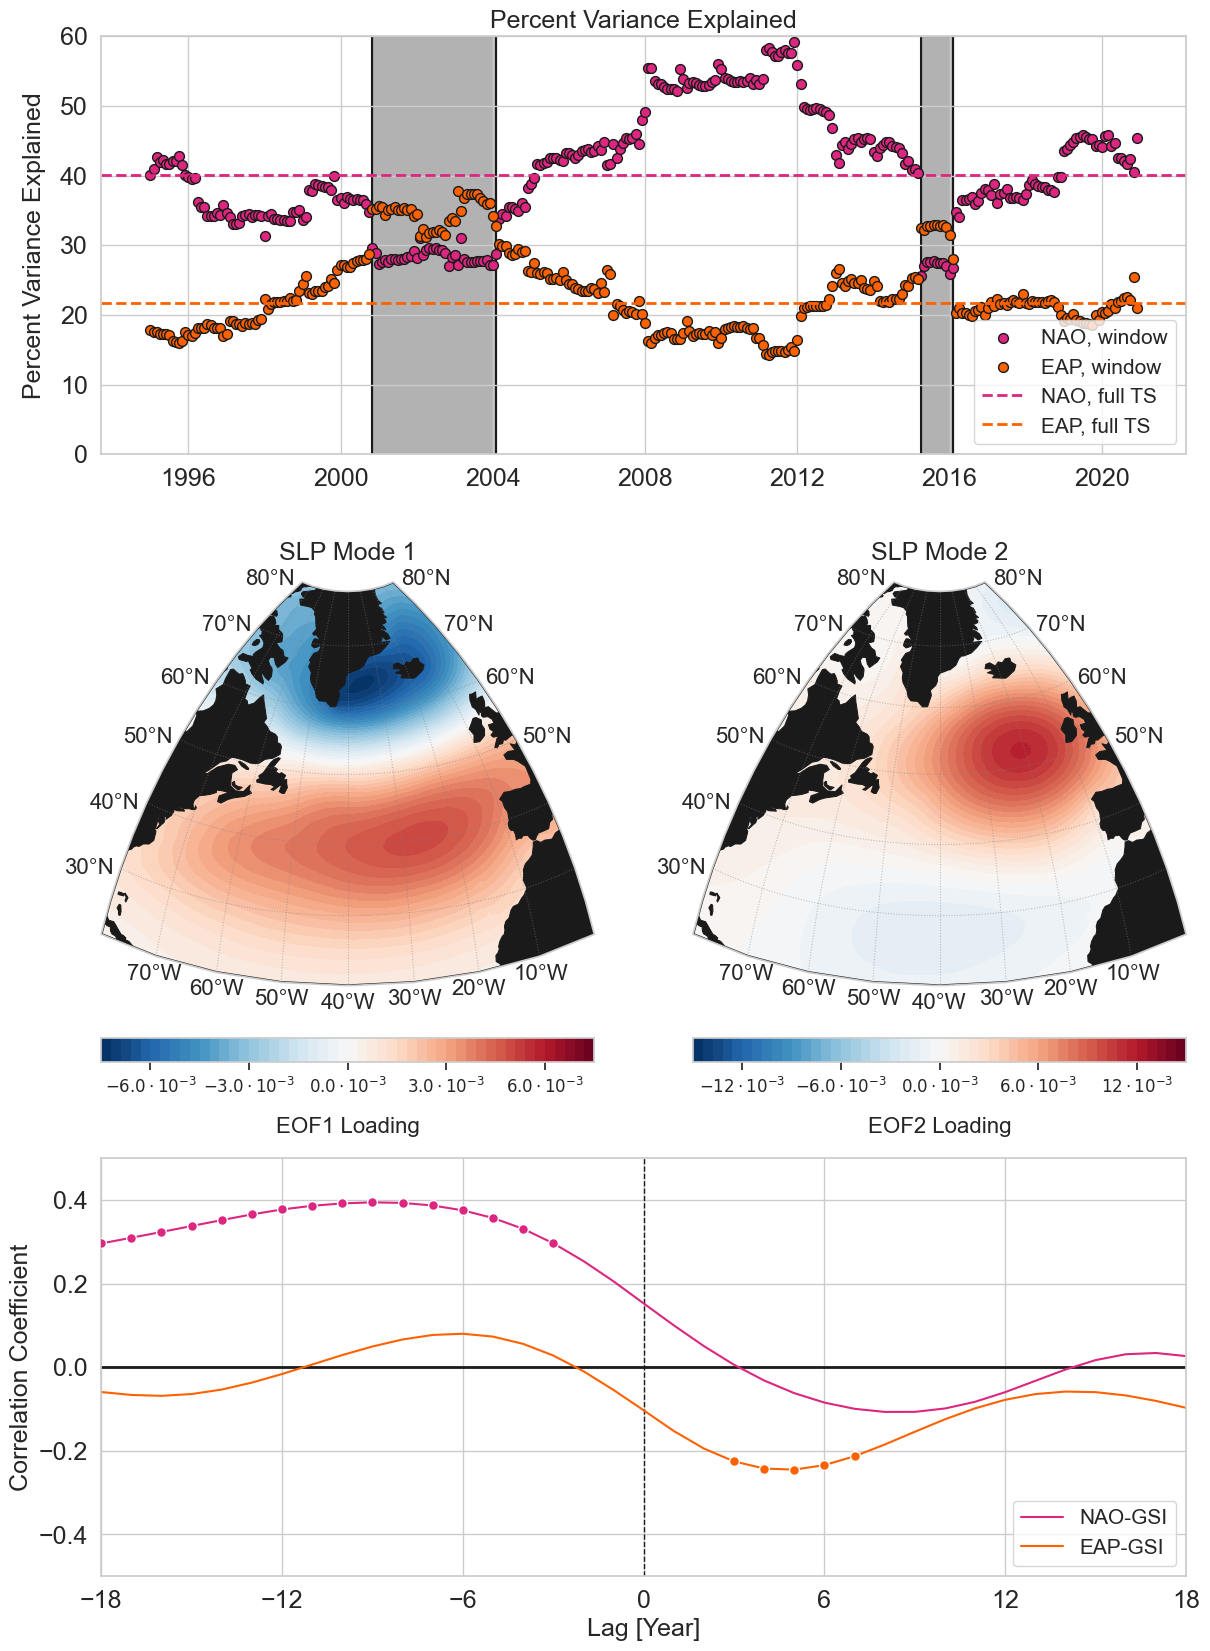

In [45]:
style   = sns.set_style("whitegrid")

fig = plt.figure(figsize=(14, 20))
gs  = gridspec.GridSpec(3, 2, height_ratios=[1, 1.25, 1], figure=fig)

# -------------------------------------------
# ---- Top Row: Percent Variance Scatter ----
# -------------------------------------------
ax_top = fig.add_subplot(gs[0, :])  # span both cols

pv_all1 = ax_top.scatter(ds_modes.time_c, ds_modes.nao_pv, 50, c=nao_c, edgecolors='k', label='NAO, window')
pv_all2 = ax_top.scatter(ds_modes.time_c, ds_modes.eap_pv, 50, c=eap_c, edgecolors='k', label='EAP, window')

pv_nao_mn = ax_top.axhline(per_var_full[0]*100, color=nao_c, linewidth=2, linestyle='--', label='NAO, full TS')
pv_eap_mn = ax_top.axhline(per_var_full[1]*100, color=eap_c, linewidth=2, linestyle='--', label='EAP, full TS')

ax_top.set_title('Percent Variance Explained', fontsize = 18)

#which_nao = ax_top.scatter(ds_modes.time_c[10], ds_modes.nao_pv[10], 250, c='#ffb000', zorder=0)
#which_eap = ax_top.scatter(ds_modes.time_c[10], ds_modes.eap_pv[10], 250, c='#ffb000', zorder=0)

ax_top.axvspan(ds_modes.time_c[ds_modes.nao_mode.data == 2][0].data,
            ds_modes.time_c[ds_modes.nao_mode.data == 2][39].data,
            alpha=0.3, color='black', zorder=0)
ax_top.axvline(ds_modes.time_c[ds_modes.nao_mode.data == 2][0].data, color='k', zorder=0)
ax_top.axvline(ds_modes.time_c[ds_modes.nao_mode.data == 2][39].data, color='k', zorder=0)

ax_top.axvspan(ds_modes.time_c[ds_modes.nao_mode.data == 2][40].data,
            ds_modes.time_c[ds_modes.nao_mode.data == 2][-1].data,
            alpha=0.3, color='black', zorder=0)
ax_top.axvline(ds_modes.time_c[ds_modes.nao_mode.data == 2][40].data, color='k', zorder=0)
ax_top.axvline(ds_modes.time_c[ds_modes.nao_mode.data == 2][-1].data, color='k', zorder=0)

ax_top.set_ylabel('Percent Variance Explained', fontsize=18, labelpad=10)
ax_top.tick_params(axis='both', labelsize=18)
ax_top.set_ylim(0, 60)
ax_top.legend(fontsize=15, loc = 'lower right')

# -------------------------------------------
# ---- Middle Row: SLP Modes ----------------
# -------------------------------------------

# --- MODE ONE ------------------------------
ax_mid_left = fig.add_subplot(3, 2, 3, projection=ccrs.Orthographic(central_longitude=-40, central_latitude=35))
ax_mid_left.set_title('SLP Mode 1', fontsize = 18)

var_to_plot   = nao_sp.copy()
cmax          = 0.0075
var_to_plot.data[var_to_plot.data > cmax] = cmax
var_to_plot.data[var_to_plot.data < -cmax] = -cmax

bbox = [-80, 0, 20, 80]
fig, ax_mid_left, _ = init_orthomap(bboxplot=bbox, ax=ax_mid_left)
ax_mid_left = add_coast_grid(ax_mid_left, bbox, fill_color='k', line_color='k')

levels = np.linspace(-cmax, cmax, 51)

colorplot = ax_mid_left.contourf(
    var_to_plot.longitude, var_to_plot.latitude, var_to_plot,
    transform=proj, levels=levels, cmap='RdBu_r', zorder=0
)

cbar = fig.colorbar(
    colorplot, ax=ax_mid_left, fraction=0.057, pad=0.1, orientation='horizontal',
    ticks=np.linspace(-0.006, 0.006, 5)
)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticklabels([
    r'$-6.0 \cdot 10^{-3}$', r'$-3.0 \cdot 10^{-3}$',
    r'$0.0 \cdot 10^{-3}$', r'$3.0 \cdot 10^{-3}$',
    r'$6.0 \cdot 10^{-3}$'
])
cbar.set_label('EOF1 Loading', size=16, labelpad=15)

# --- MODE TWO ------------------------------

ax_mid_right = fig.add_subplot(3, 2, 4, projection=ccrs.Orthographic(central_longitude=-40, central_latitude=35))
ax_mid_right.set_title('SLP Mode 2', fontsize = 18)
var_to_plot   = eap_sp.copy()
cmax          = 0.015
var_to_plot.data[var_to_plot.data > cmax] = cmax
var_to_plot.data[var_to_plot.data < -cmax] = -cmax

bbox = [-80, 0, 20, 80]
fig, ax_mid_right, _ = init_orthomap(bboxplot=bbox, ax=ax_mid_right)
ax_mid_right = add_coast_grid(ax_mid_right, bbox, fill_color='k', line_color='k')

levels = np.linspace(-cmax, cmax, 51)

colorplot = ax_mid_right.contourf(
    nao_sp.longitude, nao_sp.latitude, var_to_plot,
    transform=proj, levels=levels, cmap='RdBu_r', zorder=0
)

cbar = fig.colorbar(
    colorplot, ax=ax_mid_right, fraction=0.057, pad=0.1, orientation='horizontal',
    ticks=np.linspace(-0.012, 0.012, 5)
)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticklabels([r'$-12 \cdot 10^{-3}$', r'$-6.0 \cdot 10^{-3}$', r'$0.0 \cdot 10^{-3}$', 
                     r'$6.0 \cdot 10^{-3}$', r'$12 \cdot 10^{-3}$'])
cbar.set_label('EOF2 Loading', size='16', labelpad=15)

# -------------------------------------------
# ---- Bottom Row: Lead/Lags ----------------
# -------------------------------------------
ax_bot = fig.add_subplot(gs[2, :])  # span both cols

zline   = ax_bot.axhline(0, color='k', linewidth=2)
yline   = ax_bot.axvline(0, color='k', linewidth=1, linestyle = '--')

# --- NAO/GSI lead/lag --- 
lags_nao  = ax_bot.plot(lags_array,nao_gsi_corrs, c = nao_c, label = 'NAO-GSI')
sigs_nao  = ax_bot.scatter(lags_array[ix_ng], nao_gsi_corrs[ix_ng], s=50, color = nao_c, edgecolors='w',zorder = 10)

# --- EAP/GSI lead/lag --- 
lags_eap  = ax_bot.plot(lags_array,eap_gsi_corrs, c = eap_c, label = 'EAP-GSI')
sigs_eao  = ax_bot.scatter(lags_array[ix_eg], eap_gsi_corrs[ix_eg], s=50, color = eap_c, edgecolors='w',zorder = 10)

ax_bot.tick_params(axis='both', labelsize=18)
ytix = ax_bot.set_xticks(np.arange(-18,19,6))
ylab = ax_bot.set_ylabel('Correlation Coefficient', fontsize = 18)
xlab = ax_bot.set_xlabel('Lag [Year]',fontsize = 18)
ax_bot.set_xlim(lags_array[0],lags_array[-1])
ax_bot.set_ylim(-0.5,0.5)
ax_bot.legend(fontsize=15, loc = 'lower right')
plt.savefig(fig_path + 'composite_full_time_series.png', format='png', bbox_inches="tight",dpi=500)

## (3) Now for each window 

In [ ]:
window_sz = 48
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    for c in range(len(gsi_f)-(window_sz)):
        # --- Slice SLP ---
        slp_temp = ds_slp['msl'].sel(time = slice(ds_slp['msl'].time[c].data, ds_slp['msl'].time[c+window_sz].data))
        
        # --- Calculate modes ---
        eofs_temp, pcs_temp, per_var_temp, _ = calc_eofs(slp_temp, num_modes=4)
        mode_one_temp = eofs_temp[0,:,:]
        mode_two_temp = eofs_temp[1,:,:]
        
        # --- Correct the sign of the modes ---
        corr_nao_temp = xr.corr(nao_sp,eofs_temp[0,:,:])
        corr_eap_temp = xr.corr(nao_sp,eofs_temp[1,:,:])
        
        if abs(corr_nao_temp) > abs(corr_eap_temp):
            sign_nao = xr.corr(nao_sp,eofs_temp[0,:,:])
            sign_eap = xr.corr(eap_sp,eofs_temp[1,:,:])
            if sign_nao < 0:
                mode_one_temp = - mode_one_temp
            if sign_eap < 0 :
                mode_two_temp = - mode_two_temp
            
        else:
            sign_nao = xr.corr(nao_sp,eofs_temp[1,:,:])
            sign_eap = xr.corr(eap_sp,eofs_temp[0,:,:])
            if sign_nao < 0:
                mode_two_temp = - mode_two_temp
            if sign_eap < 0 :
                mode_one_temp = - mode_one_temp
        
        # --- Slice time series ---
        gsi_temp   = gsi_f.sel(time = slice(gsi_f.time[c].data,gsi_f.time[c+window_sz].data))
        nao_temp   = nao_f.sel(time = slice(nao_f.time[c].data,nao_f.time[c+window_sz].data))
        eap_temp   = eap_f.sel(time = slice(eap_f.time[c].data,eap_f.time[c+window_sz].data))
        
        # --- NAO/GSI lead/lags ---
        nao_gsi_temp = lagged_corr(nao_temp, gsi_temp, n_lags)                 # Calculate Lagged Correlations
        nao_gsi_temp = np.array(nao_gsi_temp)                                  # Convert to array
        lci_nao_gsi_temp,uci_nao_gsi_temp = get_cis(nao_temp, gsi_temp,n_lags) # Calculate confidence intervals
        
        ix_nao_gsi_temp = []                                                   # Get sig points
        for l in range(len(nao_gsi_temp)):
            if nao_gsi_temp[l] > uci_nao_gsi_temp[l] or nao_gsi_temp[l] < lci_nao_gsi_temp[l]:
                ix_nao_gsi_temp.append(l)
        
        # --- EAP/GSI lead/lags ---
        eap_gsi_temp = lagged_corr(eap_temp, gsi_temp, n_lags)      # Calculate Lagged Correlations
        eap_gsi_temp = np.array(eap_gsi_temp)                       # Convert to array
        lci_eap_gsi_temp,uci_eap_gsi_temp = get_cis(eap_temp, gsi_temp,n_lags)      # Calculate confidence intervals
        
        ix_eap_gsi_temp = []                                                   # Get sig points
        for l in range(len(eap_gsi_temp)):
            if eap_gsi_temp[l] > uci_eap_gsi_temp[l] or eap_gsi_temp[l] < lci_eap_gsi_temp[l]:
                ix_eap_gsi_temp.append(l)
        
        # --- Plot (this should be a function but I'm tired ---
        style   = sns.set_style("whitegrid")
            
        fig = plt.figure(figsize=(14, 20))
        gs  = gridspec.GridSpec(3, 2, height_ratios=[1, 1.25, 1], figure=fig)
        tit = fig.suptitle(str(gsi_f.time[c].dt.year.data) + '-' + str(gsi_f.time[c].dt.month.data).zfill(2) 
                           +  ' to ' + str(gsi_f.time[c + window_sz].dt.year.data) + '-' 
                           + str(gsi_f.time[c + window_sz].dt.month.data).zfill(2),
                           fontsize = 18,fontweight = 'bold', y = 0.91)
        # -------------------------------------------
        # ---- Top Row: Percent Variance Scatter ----
        # -------------------------------------------
        ax_top = fig.add_subplot(gs[0, :])  # span both cols
            
        pv_all1 = ax_top.scatter(ds_modes.time_c, ds_modes.nao_pv, 50, c=nao_c, edgecolors='k', label='NAO, window')
        pv_all2 = ax_top.scatter(ds_modes.time_c, ds_modes.eap_pv, 50, c=eap_c, edgecolors='k', label='EAP, window')
            
        pv_nao_mn = ax_top.axhline(per_var_full[0]*100, color=nao_c, linewidth=2, linestyle='--', label='NAO, full TS')
        pv_eap_mn = ax_top.axhline(per_var_full[1]*100, color=eap_c, linewidth=2, linestyle='--', label='EAP, full TS')
            
        ax_top.set_title('Percent Variance Explained', fontsize = 15)
            
        which_nao = ax_top.scatter(ds_modes.time_c[c], ds_modes.nao_pv[c], 250, c='#ffb000', zorder=0)
        which_eap = ax_top.scatter(ds_modes.time_c[c], ds_modes.eap_pv[c], 250, c='#ffb000', zorder=0)
            
        ax_top.axvspan(ds_modes.time_c[ds_modes.nao_mode.data == 2][0].data,
                       ds_modes.time_c[ds_modes.nao_mode.data == 2][39].data,
                       alpha=0.3, color='black', zorder=0)
        ax_top.axvline(ds_modes.time_c[ds_modes.nao_mode.data == 2][0].data, color='k', zorder=0)
        ax_top.axvline(ds_modes.time_c[ds_modes.nao_mode.data == 2][39].data, color='k', zorder=0)
            
        ax_top.axvspan(ds_modes.time_c[ds_modes.nao_mode.data == 2][40].data,
                       ds_modes.time_c[ds_modes.nao_mode.data == 2][-1].data,
                       alpha=0.3, color='black', zorder=0)
        ax_top.axvline(ds_modes.time_c[ds_modes.nao_mode.data == 2][40].data, color='k', zorder=0)
        ax_top.axvline(ds_modes.time_c[ds_modes.nao_mode.data == 2][-1].data, color='k', zorder=0)
            
        ax_top.set_ylabel('Percent Variance Explained', fontsize=18, labelpad=10)
        ax_top.tick_params(axis='both', labelsize=18)
        ax_top.set_ylim(0, 60)
        ax_top.legend(fontsize=15, loc = 'lower right')
            
        # -------------------------------------------
        # ---- Middle Row: SLP Modes ----------------
        # -------------------------------------------
            
        # --- MODE ONE ------------------------------
        ax_mid_left = fig.add_subplot(3, 2, 3, projection=ccrs.Orthographic(central_longitude=-40, central_latitude=35))
        ax_mid_left.set_title('SLP Mode 1', fontsize = 15)
            
        cmax          = 0.015
        mode_one_temp.data[mode_one_temp.data > cmax] = cmax
        mode_one_temp.data[mode_one_temp.data < -cmax] = -cmax
            
        bbox = [-80, 0, 20, 80]
        fig, ax_mid_left, _ = init_orthomap(bboxplot=bbox, ax=ax_mid_left)
        ax_mid_left = add_coast_grid(ax_mid_left, bbox, fill_color='k', line_color='k')
            
        levels = np.linspace(-cmax, cmax, 51)
            
        colorplot = ax_mid_left.contourf(
            mode_one_temp.longitude, mode_one_temp.latitude, mode_one_temp,
            transform=proj, levels=levels, cmap='RdBu_r', zorder=0
        )
            
        cbar = fig.colorbar(
            colorplot, ax=ax_mid_left, fraction=0.057, pad=0.1, orientation='horizontal',
            ticks=np.linspace(-0.012, 0.012, 5)
            )
        cbar.ax.tick_params(labelsize=12)
        cbar.set_ticklabels([r'$-12 \cdot 10^{-3}$', r'$-6.0 \cdot 10^{-3}$', r'$0.0 \cdot 10^{-3}$', 
                             r'$6.0 \cdot 10^{-3}$', r'$12 \cdot 10^{-3}$'])
        cbar.set_label('EOF1 Loading', size='12', labelpad=10)
            
        # --- MODE TWO ------------------------------
            
        ax_mid_right = fig.add_subplot(3, 2, 4, projection=ccrs.Orthographic(central_longitude=-40, central_latitude=35))
        ax_mid_right.set_title('SLP Mode 2', fontsize = 15)
        
        cmax          = 0.015
        mode_two_temp.data[mode_two_temp.data > cmax] = cmax
        mode_two_temp.data[mode_two_temp.data < -cmax] = -cmax
            
        bbox = [-80, 0, 20, 80]
        fig, ax_mid_right, _ = init_orthomap(bboxplot=bbox, ax=ax_mid_right)
        ax_mid_right = add_coast_grid(ax_mid_right, bbox, fill_color='k', line_color='k')
            
        levels = np.linspace(-cmax, cmax, 51)
            
        colorplot = ax_mid_right.contourf(
            mode_two_temp.longitude, mode_two_temp.latitude, mode_two_temp,
            transform=proj, levels=levels, cmap='RdBu_r', zorder=0
        )
            
        cbar = fig.colorbar(
            colorplot, ax=ax_mid_right, fraction=0.057, pad=0.1, orientation='horizontal',
            ticks=np.linspace(-0.012, 0.012, 5)
        )
        cbar.ax.tick_params(labelsize=12)
        cbar.set_ticklabels([r'$-12 \cdot 10^{-3}$', r'$-6.0 \cdot 10^{-3}$', r'$0.0 \cdot 10^{-3}$', 
                             r'$6.0 \cdot 10^{-3}$', r'$12 \cdot 10^{-3}$'])
        cbar.set_label('EOF2 Loading', size='12', labelpad=10)
            
        # -------------------------------------------
        # ---- Bottom Row: Lead/Lags ----------------
        # -------------------------------------------
        ax_bot = fig.add_subplot(gs[2, :])  # span both cols
        ax_bot.set_title('Lead-Lag Correlations', fontsize = 15)
        
        zline   = ax_bot.axhline(0, color='k', linewidth=2)
        yline   = ax_bot.axvline(0, color='k', linewidth=1, linestyle = '--')
            
        # --- NAO/GSI lead/lag --- 
        lags_nao  = ax_bot.plot(lags_array,nao_gsi_corrs, c = nao_c, alpha = 0.3)
        sigs_nao  = ax_bot.scatter(lags_array[ix_ng], nao_gsi_corrs[ix_ng], s=50, color = nao_c, alpha = 0.3, edgecolors='w',zorder = 10)
            
        # --- EAP/GSI lead/lag --- 
        lags_eap  = ax_bot.plot(lags_array,eap_gsi_corrs, c = eap_c, alpha = 0.3)
        sigs_eao  = ax_bot.scatter(lags_array[ix_eg], eap_gsi_corrs[ix_eg], s=50, color = eap_c, alpha = 0.3, edgecolors='w',zorder = 10)
        
        # --- NAO/GSI lead/lag WINDOW --- 
        lags_nao  = plt.plot(lags_array,nao_gsi_temp, c = nao_c, label = 'NAO-GSI')
        sigs_nao  = plt.scatter(lags_array[ix_nao_gsi_temp], nao_gsi_temp[ix_nao_gsi_temp], s=50, color = nao_c, edgecolors='w',zorder = 10)
                
        # --- EAP/GSI lead/lag WINDOW --- 
        lags_eap  = plt.plot(lags_array,eap_gsi_temp, c = eap_c, label = 'EAP-GSI')
        sigs_eao  = plt.scatter(lags_array[ix_eap_gsi_temp], eap_gsi_temp[ix_eap_gsi_temp], s=50, color = eap_c, edgecolors='w',zorder = 10)
        
        
        ax_bot.tick_params(axis='both', labelsize=18)
        ytix = ax_bot.set_xticks(np.arange(-18,19,6))
        ylab = ax_bot.set_ylabel('Correlation Coefficient', fontsize = 18)
        xlab = ax_bot.set_xlabel('Lag [Year]',fontsize = 18)
        ax_bot.set_xlim(lags_array[0],lags_array[-1])
        ax_bot.set_ylim(-1,1)
        ax_bot.legend(fontsize=15, loc = 'lower right')
        plt.savefig(fig_path + 'composites/composite_' + str(gsi_f.time[c].dt.year.data) + str(gsi_f.time[c].dt.month.data).zfill(2) + '.png', format='png', bbox_inches="tight",dpi=500)
        plt.close()

## (4) Save plots as GIF

In [ ]:
make_gif_from_folder(fig_path + 'composites', output_path = fig_path + 'composites.gif', duration=300)